In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sympy import zeros, Matrix, symbols
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import os
import pickle

# Import scenario properties
with open(os.path.join(os.getcwd(), '../scenario-properties.pkl'), 'rb') as f:
    scen_properties = pickle.load(f)

In [6]:
T = pd.read_csv(r'D:\ucl\pyssem\pyssem\utils\launch\data\x0_launch_repeatlaunch_2018to2022_megaconstellationLaunches_Constellations.csv')
# Read the data from the CSV file

def julian_to_datetime(julian_date):
    # Julian Date for Unix epoch (1970-01-01)
    JULIAN_EPOCH = 2440587.5
    try:
        # Calculate the number of days from the Unix epoch
        days_from_epoch = julian_date - JULIAN_EPOCH
        # Create a datetime object for the Unix epoch and add the calculated days
        unix_epoch = datetime(1970, 1, 1)
        result_date = unix_epoch + timedelta(days=days_from_epoch)
        return result_date
    except OverflowError as e:
        # Handle dates that are out of range
        print(f"Date conversion error: {e}")
        return None
    
def define_object_class(T):
    """
    Define the object class of each object in the traffic model.
    Adds them to a new column named "obj_type" or overwrites the existing column.

    :param T: list of launches
    :type T: pandas.DataFrame
    """

    T['obj_class'] = "Unknown"

    # Classify Rocket Bodies
    T.loc[T['obj_type'] == 1, 'obj_class'] = "Rocket Body"

    # Classify Satellites
    T.loc[(T['obj_type'] == 2) & (T['stationkeeping'] != 0) & (T['stationkeeping'] < 5), 'obj_class'] = "Station-keeping Satellite"
    T.loc[(T['obj_type'] == 2) & (T['stationkeeping'] == 0), 'obj_class'] = "Non-station-keeping Satellite"
    T.loc[(T['obj_type'] == 2) & (T['stationkeeping'] == 5), 'obj_class'] = "Coordinated Satellite"
    T.loc[(T['obj_type'] == 2) & (T['stationkeeping'] == 6), 'obj_class'] = "Candidate Satellite"

    # Classify Debris
    T.loc[T['obj_type'].isin([3, 4]), 'obj_class'] = "Debris"

    # Count unclassified rows
    unclassed_rows = (T['obj_class'] == "Unknown").sum()
    if unclassed_rows > 0:
        print(f'\t{unclassed_rows} Unclassified rows remain.')

    return T

    
T['epoch_start_datime'] = T['epoch_start'].apply(lambda x: julian_to_datetime(x))

if 'obj_class' not in T.columns:
    T = define_object_class(T)  # Make sure this function is defined and imported

# Calculate Apogee, Perigee, and Altitude
T['apogee'] = T['sma'] * (1 + T['ecc'])
T['perigee'] = T['sma'] * (1 - T['ecc'])
T['alt'] = (T['apogee'] + T['perigee']) / 2 - scen_properties.re

In [13]:
def find_alt_bin(altitude, scen_properties):
    # Convert altitude ranges to numpy arrays for vectorized operations
    lower = np.array(scen_properties.R0[:-1])
    upper = np.array(scen_properties.R0[1:])
    
    # Create a boolean array where True indicates altitude is within the shell bounds
    shell_logic = (lower < altitude) & (altitude <= upper)
    
    # Find the index (or indices) where shell_logic is True
    shell_indices = np.where(shell_logic)[0]
    
    # Return the first index if found, otherwise return NaN
    shell_index = shell_indices[0] + 1 if shell_indices.size > 0 else np.nan
    return shell_index
def find_mass_bin(mass, scen_properties, species_cell):
    """
    Find the mass bin for a given mass.

    :param mass: Mass of the object in kg
    :type mass: float
    :param scen_properties: The scenario properties object
    :type scen_properties: ScenarioProperties
    :param species_cell: The species cell to find the mass bin for
    :type species_cell: Species
    :return: The mass bin for the given mass
    :rtype: int
    """
    for species in species_cell:
        if species.mass_lb <= mass < species.mass_ub:
            return species.sym_name
    
    return None



# Map species type based on object class
species_dict = {"Non-station-keeping Satellite": "Sns",
                "Rocket Body": "B",
                "Station-keeping Satellite": "Su",
                "Coordinated Satellite": "S",
                "Debris": "N",
                "Candidate Satellite": "C"}

T['species_class'] = T['obj_class'].map(species_dict)

# Initialize an empty DataFrame for new data
T_new = pd.DataFrame()

# Loop through object classes and assign species based on mass
for obj_class in T['obj_class'].unique():
        species_class = species_dict.get(obj_class)
        if species_class in scen_properties.species_cells:
                # if species class is candidate satellite, continue
                if len(scen_properties.species_cells[species_class]) == 1:
                        T_obj_class = T[T['obj_class'] == obj_class].copy()
                        T_obj_class['species'] = scen_properties.species_cells[species_class][0].sym_name
                        T_new = pd.concat([T_new, T_obj_class])
                else:
                        species_cells = scen_properties.species_cells[species_class]
                        T_obj_class = T[T['obj_class'] == obj_class].copy()
                        T_obj_class['species'] = T_obj_class['mass'].apply(find_mass_bin, args=(scen_properties, species_cells)) 
                        T_new = pd.concat([T_new, T_obj_class])

# Assign objects to corresponding altitude bins
T_new['alt_bin'] = T_new['alt'].apply(find_alt_bin, args=(scen_properties,))


# Filter T_new to include only species present in scen_properties
T_new = T_new[T_new['species_class'].isin(scen_properties.species_cells.keys())]

# Initial population
x0_all = T_new[T_new['epoch_start_datime'] < scen_properties.start_date]
print(len(x0_all))

x0 = x0_all[x0_all['alt'] <= scen_properties.max_altitude]
print(len(x0))

# Create a pivot table, keep alt_bin
df = x0.pivot_table(index='alt_bin', columns='species', aggfunc='size', fill_value=0)

# Create a new data frame with column names like scenario_properties.species_sym_names and rows of length n_shells
x0_summary = pd.DataFrame(index=range(scen_properties.n_shells), columns=scen_properties.species_names).fillna(0)
x0_summary.index.name = 'alt_bin'

# Merge the two dataframes
for column in df.columns:
    if column in x0_summary.columns:
        x0_summary[column] = df[column]

# fill NaN with 0
x0_summary.fillna(0, inplace=True)
print(x0_summary.sum().sum())

# # Future Launch Model
flm_steps = pd.DataFrame()

time_increment_per_step = scen_properties.simulation_duration / scen_properties.steps

time_steps = [scen_properties.start_date + timedelta(days=365.25 * time_increment_per_step * i) 
            for i in range(scen_properties.steps + 1)]    

for start, end in zip(time_steps[:-1], time_steps[1:]):
    flm_step = T_new[(T_new['epoch_start_datime'] >= start) & (T_new['epoch_start_datime'] < end)]
    print(f"Step: {start} - {end}, Objects: {flm_step.shape[0]}")
    flm_summary = flm_step.groupby(['alt_bin', 'species']).size().unstack(fill_value=0)

    # all objects aren't always in shells, so you need to these back in. 
    flm_summary = flm_summary.reindex(range(0, scen_properties.n_shells), fill_value=0)

    flm_summary.reset_index(inplace=True)
    flm_summary.rename(columns={'index': 'alt_bin'}, inplace=True)

    flm_summary['epoch_start_date'] = start # Add the start date to the table for reference
    flm_steps = pd.concat([flm_steps, flm_summary])

#      alt_bin species
# 242     10.0    None
# 257     11.0    None
# 262     14.0    None


16313
13983
0
Step: 2022-01-03 00:00:00 - 2022-07-04 15:00:00, Objects: 1795
Step: 2022-07-04 15:00:00 - 2023-01-03 06:00:00, Objects: 2277
Step: 2023-01-03 06:00:00 - 2023-07-04 21:00:00, Objects: 1129
Step: 2023-07-04 21:00:00 - 2024-01-03 12:00:00, Objects: 1139
Step: 2024-01-03 12:00:00 - 2024-07-04 03:00:00, Objects: 1410
Step: 2024-07-04 03:00:00 - 2025-01-02 18:00:00, Objects: 1364
Step: 2025-01-02 18:00:00 - 2025-07-04 09:00:00, Objects: 3164
Step: 2025-07-04 09:00:00 - 2026-01-03 00:00:00, Objects: 3206
Step: 2026-01-03 00:00:00 - 2026-07-04 15:00:00, Objects: 3500
Step: 2026-07-04 15:00:00 - 2027-01-03 06:00:00, Objects: 3511
Step: 2027-01-03 06:00:00 - 2027-07-04 21:00:00, Objects: 3830
Step: 2027-07-04 21:00:00 - 2028-01-03 12:00:00, Objects: 3832
Step: 2028-01-03 12:00:00 - 2028-07-04 03:00:00, Objects: 4204
Step: 2028-07-04 03:00:00 - 2029-01-02 18:00:00, Objects: 4215
Step: 2029-01-02 18:00:00 - 2029-07-04 09:00:00, Objects: 4255
Step: 2029-07-04 09:00:00 - 2030-01-03 00

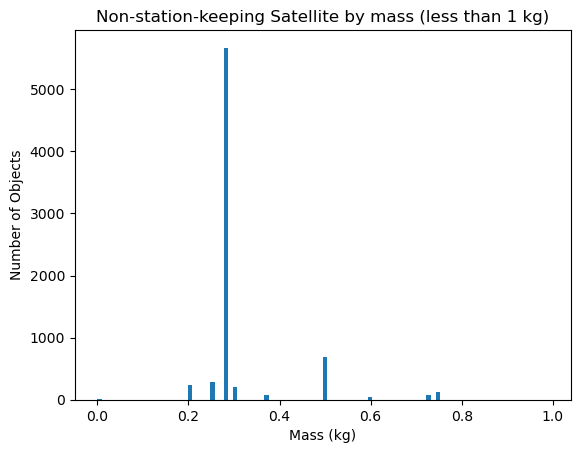

In [14]:
# show the rows in in T that have the same adept_id as the rows in lost 
test = T[T['obj_class'] == "Non-station-keeping Satellite"]
test = test[test['mass'] < 1]

# plot a histogram of the mass of the objects
plt.hist(test['mass'], bins=100)
plt.xlabel('Mass (kg)')
plt.ylabel('Number of Objects')
plt.title('Non-station-keeping Satellite by mass (less than 1 kg)')
plt.show()

In [22]:
import scipy.io
import pandas as pd
import numpy as np

def matsats2ASEM(matsats):
    radiusearthkm = 6378.137
    
    # Column indices in matsats array
    idx_a = 0
    idx_ecco = 1
    idx_inclo = 2
    idx_nodeo = 3
    idx_argpo = 4
    idx_mo = 5
    idx_bstar = 6
    idx_mass = 7
    idx_radius = 8
    idx_error = 9
    idx_controlled = 10
    idx_a_desired = 11
    idx_missionlife = 12
    idx_constel = 13
    idx_date_created = 14
    idx_launch_date = 15
    idx_objectclass = 16
    idx_ID = 17
    
    # Initialize the DataFrame
    asem = pd.DataFrame()

    # Calculate ASEM values
    asem['sma'] = matsats[:, idx_a] * radiusearthkm  # SMA [km]
    asem['ecc'] = matsats[:, idx_ecco]              # Ecc [-]
    asem['inc'] = np.degrees(matsats[:, idx_inclo])  # Inc [deg]
    asem['raan'] = np.degrees(matsats[:, idx_nodeo]) # RAAN [deg]
    asem['aop'] = np.degrees(matsats[:, idx_argpo])  # AOP [deg]
    asem['ma'] = np.degrees(matsats[:, idx_mo])     # Mean Anomaly [deg]
    asem['mass'] = matsats[:, idx_mass]             # Mass [kg]
    asem['size'] = matsats[:, idx_radius] * 2       # Diameter [m]
    asem['area'] = np.pi * matsats[:, idx_radius]**2 # Area [m^2]

    # Object type flag
    asem['obj_type'] = 0
    asem.loc[matsats[:, idx_objectclass] == 5, 'obj_type'] = 1  # Rocket Body
    asem.loc[matsats[:, idx_objectclass] == 1, 'obj_type'] = 2  # Payload

    # Disposal option flag
    asem['disp_option'] = 0

    # Stationkeeping flag
    asem['stationkeeping'] = 0
    asem.loc[matsats[:, idx_controlled] == 1, 'stationkeeping'] = 3  # Controlled

    # Epochs
    asem['epoch_start'] = matsats[:, idx_launch_date]  # Start or launch date [JD]
    asem['epoch_end'] = asem['epoch_start'] + matsats[:, idx_missionlife] * 365.2425  # [JD]

    # Object ID
    asem['adept_id'] = matsats[:, idx_ID]

    # Weighting Factor
    asem['weight'] = 1

    return asem

# Load the .mat file
mat_data = scipy.io.loadmat(r'D:\ucl\pyssem\pyssem\utils\launch\data\x0.mat')

# Access the initial_data array
initial_data = mat_data['initial_data']

# Convert to Pandas DataFrame
df = pd.DataFrame(initial_data)

# Apply the matsats2ASEM function
asem_df = matsats2ASEM(df.values)

# find the number of objects with a mass of 0
no_mass = asem_df[asem_df['mass'] == 0]
no_mass

asem_df

,sma,ecc,inc,raan,aop,ma,mass,size,area,obj_type,disp_option,stationkeeping,epoch_start,epoch_end,adept_id,weight
0,8618.593,0.184635,34.2506,135.9927,211.5625,135.9927,1.460000,0.160000,0.020106,0,0,0,2436279.5,2436279.5,0.0,1
1,8120.931,0.146394,32.8628,282.2643,94.6042,282.2643,9.710000,0.510022,0.204300,0,0,0,2436616.5,2436616.5,0.0,1
2,8315.964,0.166247,32.9137,59.7451,282.2521,59.7451,22.790000,1.137981,1.017091,0,0,0,2436616.5,2436616.5,0.0,1
3,8815.994,0.202761,34.2718,155.0332,197.0792,155.0332,22.790000,1.137981,1.017091,0,0,0,2436279.5,2436279.5,0.0,1
4,8259.940,0.166109,33.3414,209.9872,158.1000,209.9872,67.390000,1.185348,1.103524,0,0,0,2436829.5,2436829.5,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19079,7152.322,0.010518,98.7298,212.6552,148.1059,212.6552,78.173716,1.470419,1.698134,0,0,0,2459894.5,2459894.5,0.0,1
19080,7150.256,0.012539,98.6823,207.7555,153.0222,207.7555,83.297170,0.913654,0.655622,0,0,0,2459894.5,2459894.5,0.0,1
19081,7131.089,0.013804,98.7164,219.5227,141.5888,219.5227,116.787717,1.782133,2.494424,0,0,0,2459894.5,2459894.5,0.0,1
19082,7150.596,0.009313,98.5987,197.2059,163.2243,197.2059,5.788838,0.612433,0.294583,0,0,0,2459894.5,2459894.5,0.0,1


In [33]:
# sum all values across scenario_properties.x0
scen_properties.FLM_steps.epoch_start_date.unique()

<DatetimeArray>
['2022-01-03 00:00:00', '2022-07-04 15:00:00', '2023-01-03 06:00:00',
 '2023-07-04 21:00:00', '2024-01-03 12:00:00', '2024-07-04 03:00:00',
 '2025-01-02 18:00:00', '2025-07-04 09:00:00', '2026-01-03 00:00:00',
 '2026-07-04 15:00:00',
 ...
 '2117-01-03 18:00:00', '2117-07-05 09:00:00', '2118-01-04 00:00:00',
 '2118-07-05 15:00:00', '2119-01-04 06:00:00', '2119-07-05 21:00:00',
 '2120-01-04 12:00:00', '2120-07-05 03:00:00', '2121-01-03 18:00:00',
 '2121-07-05 09:00:00']
Length: 200, dtype: datetime64[ns]

In [31]:
# Matlab's x0
mat_x0 = pd.read_csv(r'D:\ucl\pyssem\pyssem\utils\launch\data\x0.csv')
mat_x0.sum().sum()

13983

In [39]:
scen_properties.

species,alt_bin,Sns,Su_260kg,B,N_0.567kg,N_148kg,N_6kg,N_1250kg,Su_473kg,N_260kg,S_148kg,epoch_start_date,N_0.00141372kg,N_473kg,S_750kg,S_1250kg
0,0,0,0,0,0.0,0,0,0.0,0,0.0,0,2022-01-03,NaN,NaN,NaN,NaN
1,1,1,0,0,0.0,0,0,0.0,0,0.0,0,2022-01-03,NaN,NaN,NaN,NaN
2,2,0,1,0,0.0,0,0,0.0,0,0.0,0,2022-01-03,NaN,NaN,NaN,NaN
3,3,1,0,0,0.0,0,0,0.0,0,0.0,0,2022-01-03,NaN,NaN,NaN,NaN
4,4,2,3,0,0.0,0,0,0.0,0,0.0,0,2022-01-03,NaN,NaN,NaN,NaN
5,5,1,2,2,1.0,2,1,0.0,0,0.0,0,2022-01-03,NaN,NaN,NaN,NaN
6,6,2,2,2,0.0,0,0,1.0,1,0.0,0,2022-01-03,NaN,NaN,NaN,NaN
7,7,8,6,2,0.0,2,0,0.0,2,0.0,0,2022-01-03,NaN,NaN,NaN,NaN
8,8,8,7,3,1.0,0,0,0.0,1,2.0,0,2022-01-03,NaN,NaN,NaN,NaN
9,9,23,77,6,0.0,1,1,0.0,5,0.0,0,2022-01-03,NaN,NaN,NaN,NaN
